:<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/google/lightweight_mmm/blob/main/examples/simple_end_to_end_demo.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/google/lightweight_mmm/blob/main/examples/simple_end_to_end_demo.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

# Simple End to End Demo

Welcome to the end to end demo of LightweightMMM. This is a very simple demo in 
which we showcase the basic usage and functionalities of the library.

Disclaimer: This notebook skips all exploratory data analysis and preprocessing (besides scaling) and assumes the user will do or has done it prior to engaging this point of the demo.

This notebook uses dummy data and therefore the numbers and results might not be representative of what one might get on a real dataset. 

For running chains in parallel you can set the number of CPUs at the begining of the program like the following:
`numpyro.set_host_device_count(n)`

In [ ]:
# First would be to install lightweight_mmm
!pip install --upgrade git+https://github.com/google/lightweight_mmm.git

In [ ]:
# Import jax.numpy and any other library we might need.
import jax.numpy as jnp
import numpyro

In [ ]:
# Import the relevant modules of the library
from lightweight_mmm import lightweight_mmm
from lightweight_mmm import optimize_media
from lightweight_mmm import plot
from lightweight_mmm import preprocessing
from lightweight_mmm import utils

## Organising the data for modelling

In [ ]:
SEED = 105

In [ ]:
data_size = 104 + 13
n_media_channels = 3
n_extra_features = 1

In [ ]:
media_data, extra_features, target, costs = utils.simulate_dummy_data(
    data_size=data_size,
    n_media_channels=n_media_channels,
    n_extra_features=n_extra_features)

We can then split the dataset into train and test. Lets leave only the last 13 weeks for testing in this case.

In [ ]:
# Split and scale data.
split_point = data_size - 13
# Media data
media_data_train = media_data[:split_point, ...]
media_data_test = media_data[split_point:, ...]
# Extra features
extra_features_train = extra_features[:split_point, ...]
extra_features_test = extra_features[split_point:, ...]
# Target
target_train = target[:split_point]

Scaling is essential for many modelling problems and this one is no exception.

We provide the class `CustomScaler` which behaves accordingly with `sklearn`
scalers.

In most cases you will need 3 or 4 scalers. One scaler for the media data, one
for the target and one for costs. Optionally if you are adding extra features
those might need an extra scaler. **It is very important that you save and
"carry with you" those scalers throughout your MMM journey as LighweightMMM will
allow you to re-insert these scalers at different points to ensure everything is
always in the correct scale and results. If some results don't make sense, it
might be a scaling problem.**

A few more details on CustomScaler usage:

This scaler can be used in two fashions for both the multiplication and division
operation. 
- By specifying a value to use for the scaling operation. 
- By specifying an operation used at column level to calculate the value for the
actual scaling operation.

Eg. if one wants to scale the dataset by multiply by 100 you can directly pass
multiply_by=100. Value can also be an array of an appropriate shape by which
to divide or multiply the data. But if you want to multiply by the mean value of each
column, then you can pass multiply_operation=jnp.mean (or any other operation
desired).

Operation parameters have the upper hand in the cases where both values and
operations are passed, values will be ignored in this case.

Consult the full class documentation if you still need to know more.

In this demo we divide the data on media, extra features and the target by their mean to ensure that the result has a mean of 1. This allows the model to be agnostic to the scale of the inputs (e.g. a user can use either the number of sales or the value of sales). The costs are not used in the model directly, they are only used to inform the prior distributions on the media variables (see the [model documentation](https://lightweight-mmm.readthedocs.io/en/latest/models.html) here). These costs have been scaled down by multiplying by 0.15 to reflect typical ranges in MMMs. 

In [ ]:
media_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
extra_features_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
target_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
cost_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean, multiply_by=0.15)

media_data_train = media_scaler.fit_transform(media_data_train)
extra_features_train = extra_features_scaler.fit_transform(extra_features_train)
target_train = target_scaler.fit_transform(target_train)
costs = cost_scaler.fit_transform(costs)

### Checking data quality

Before putting data into a model, the data should always be examined by hand to make sure everything is correct, and to check for potential issues that might affect the modeling process. We include a data quality check in LMMM which checks for a few common issues. This is not an exhaustive set of checks, however, and most of the exploratory data analysis will still have do be done manually based on your judgment. 

In [ ]:
correlations, variances, spend_fractions, variance_inflation_factors = preprocessing.check_data_quality(
    media_data=media_scaler.transform(media_data),
    target_data=target_scaler.transform(target),
    cost_data=costs,
    extra_features_data=extra_features_scaler.transform(extra_features))


**Step 1: Checking the correlation matrix**

The below cell shows the correlation matrix between all the features, and between each feature and the target. Very positive or very negative correlations (with an absolute value above, say, 0.7 or so) should be treated with caution. In this case you might consider dropping or merging highly correlated features. 

In [ ]:
correlations[0].style.background_gradient(cmap='RdBu', vmin=-1, vmax=1).format(precision=3)

,feature_0,feature_1,feature_2,extra_feature_0,target
feature_0,1.000,0.088,0.074,0.042,-0.038
feature_1,0.088,1.000,-0.051,0.091,0.279
feature_2,0.074,-0.051,1.000,-0.121,0.189
extra_feature_0,0.042,0.091,-0.121,1.000,0.128
target,-0.038,0.279,0.189,0.128,1.000


**Step 2: Checking the variances**

The below cell shows the variance of each feature over time. Variances which are lower than the specified low_variance_threshold or higher than the specified high_variance_threshold are marked in **red**. Make sure you are passing the scaled versions of your media_data and extra_features_data to the data quality checker for these variances before running this check!


In [ ]:
def highlight_variances(x: float, 
                        low_variance_threshold: float=1.0e-3, 
                        high_variance_threshold: float=3.0) -> str:

    if x < low_variance_threshold or x > high_variance_threshold:
      weight = 'bold'
      color = 'red'
    else:
      weight = 'normal'
      color = 'black'
    style = f'font-weight: {weight}; color: {color}'
    return style

variances.style.format(precision=4).applymap(highlight_variances)


,geo_0
feature_0,0.0057
feature_1,0.0050
feature_2,0.0049
extra_feature_0,0.0445


**Step 3: Checking the spend fractions**

This check is very straightforward. LMMM uses the total spend for each channel to set the prior on the channel's media contribution coefficient, as well as to calculate ROI later in the analysis. Thus the spend for each channel must be positive (not negative or zero), and ideally each channel should not be a negligibly small fraction of the total spend as well.

In [ ]:
def highlight_low_spend_fractions(x: float,
                                  low_spend_threshold: float=0.01) -> str:
    if x < low_spend_threshold:
      weight = 'bold'
      color = 'red'
    else:
      weight = 'normal'
      color = 'black'
    style = f'font-weight: {weight}; color: {color}'
    return style

spend_fractions.style.format(precision=4).applymap(highlight_low_spend_fractions)


,fraction of spend
feature_0,0.3334
feature_1,0.3348
feature_2,0.3318


**Step 4: Checking the variance inflation factors**

While checking the correlation matrix in step 1 is usually sufficient for detecting obvious multicollinearity in a dataset, the variance inflation factor is technically the best metric for identifying multicollinear features. Here we list the variance inflation factors for all features. If the number is too high (we use a threshold here of 7, but feel free to adjust to your use case) you might consider dropping or merging features with high variance inflation factors.

In [ ]:
def highlight_high_vif_values(x: float,
                              high_vif_threshold: float=7.0) -> str:
    if x > high_vif_threshold:
      weight = 'bold'
      color = 'red'
    else:
      weight = 'normal'
      color = 'black'
    style = f'font-weight: {weight}; color: {color}'
    return style

variance_inflation_factors.style.format(precision=4).applymap(highlight_high_vif_values)


,geo_0
feature_0,1.0162
feature_1,1.0180
feature_2,1.0236
extra_feature_0,1.0242


### Training the model

The currently available models are the following: 
- hill_adstock 
- adstock 
- carryover

In [ ]:
mmm = lightweight_mmm.LightweightMMM(model_name="carryover")

Training the model will require the following mandatory parameters: 
- media
- total_costs (one value per channel) 
- target

We can optionally also pass the following: 
- extra_features: Other variables to add to the model. 
- degrees_seasonality: Number of degrees to use for seasonality. Default is 3. 
- seasonality_frequency: Frequency of the time period used. Default is 52 as in 52 weeks per year. 
- media_names: Names of the media channels passed. 
- number_warmup: Number of warm up samples. Default is 1000. 
- number_samples: Number of samples during sampling. Default is 1000. 
- number_chains: Number of chains to sample. Default is 2.

In [ ]:
number_warmup=1000
number_samples=1000

In [ ]:
# For replicability in terms of random number generation in sampling
# reuse the same seed for different trainings.
mmm.fit(
    media=media_data_train,
    media_prior=costs,
    target=target_train,
    extra_features=extra_features_train,
    number_warmup=number_warmup,
    number_samples=number_samples,
    seed=SEED)

sample: 100%|██████████| 2000/2000 [00:51<00:00, 38.67it/s, 255 steps of size 1.50e-02. acc. prob=0.93]


You can check the summary of your trace by printing a summary:

In [ ]:
mmm.print_summary()


                                 mean       std    median      5.0%     95.0%     n_eff     r_hat
ad_effect_retention_rate[0]      0.52      0.29      0.52      0.11      1.00   2238.94      1.00
ad_effect_retention_rate[1]      0.33      0.19      0.33      0.02      0.60   1627.58      1.00
ad_effect_retention_rate[2]      0.38      0.25      0.35      0.00      0.75   1633.86      1.00
     coef_extra_features[0]      0.03      0.01      0.03      0.01      0.05   2289.04      1.00
              coef_media[0]      0.01      0.01      0.01      0.00      0.03   1899.48      1.00
              coef_media[1]      0.13      0.05      0.14      0.04      0.20    883.69      1.01
              coef_media[2]      0.07      0.05      0.07      0.00      0.14    877.16      1.00
              coef_trend[0]     -0.00      0.00     -0.00     -0.00      0.00   1278.71      1.00
                 expo_trend      0.64      0.13      0.60      0.50      0.83    874.11      1.00
                exp

We can visualise the posterior distributions of the media effects:

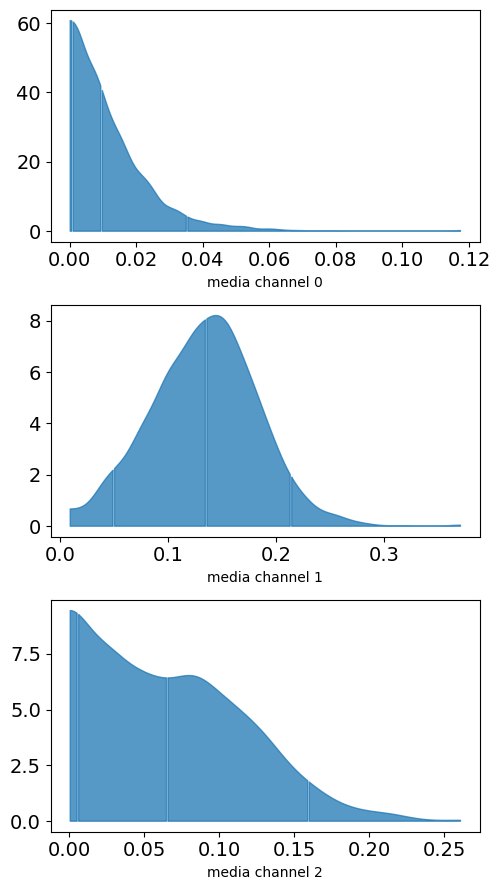

In [ ]:
plot.plot_media_channel_posteriors(media_mix_model=mmm)

**[*optional*]**

 LightweightMMM also allows you to visualize the prior and posterior distributions for every model parameter at once. Note that we use a kernel density estimator to smooth these distributions for easier interpretability; you may need to adjust the bandwidth of the smoother depending on the shapes of your distributions. 
Also, this plot **can take several minutes to run**, especially if using geo-level models. Lowering the number_of_samples_for_prior or restricting to a subset of selected_features can speed up the runtime.

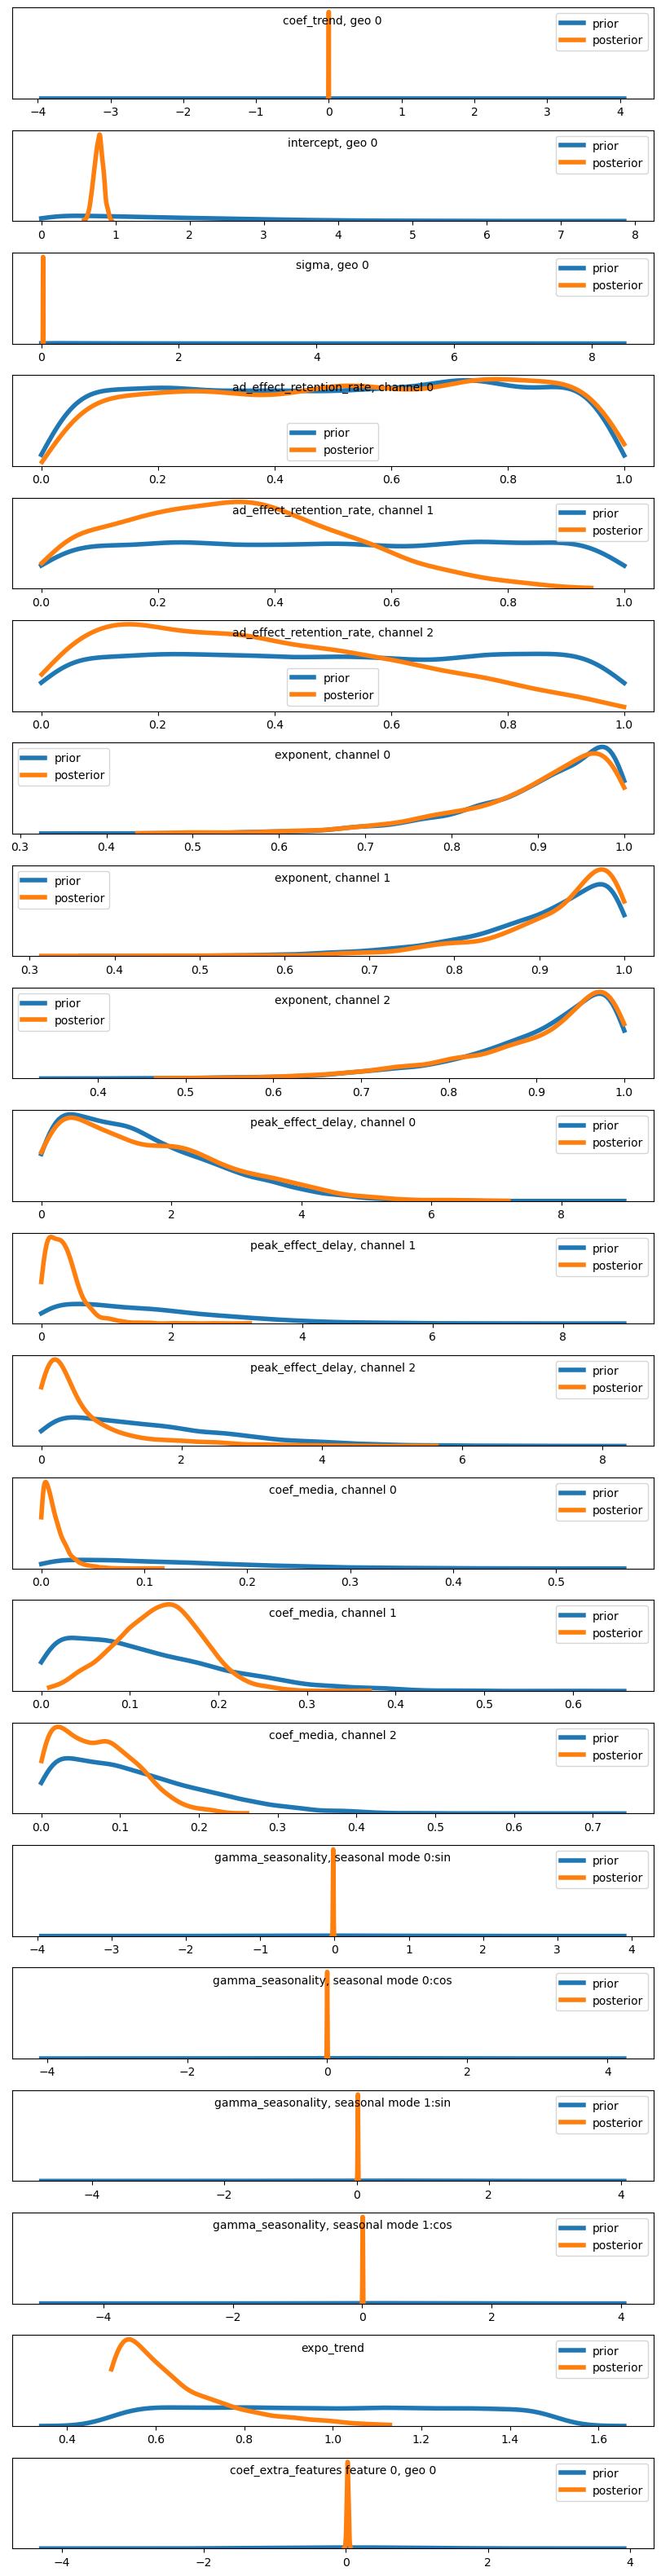

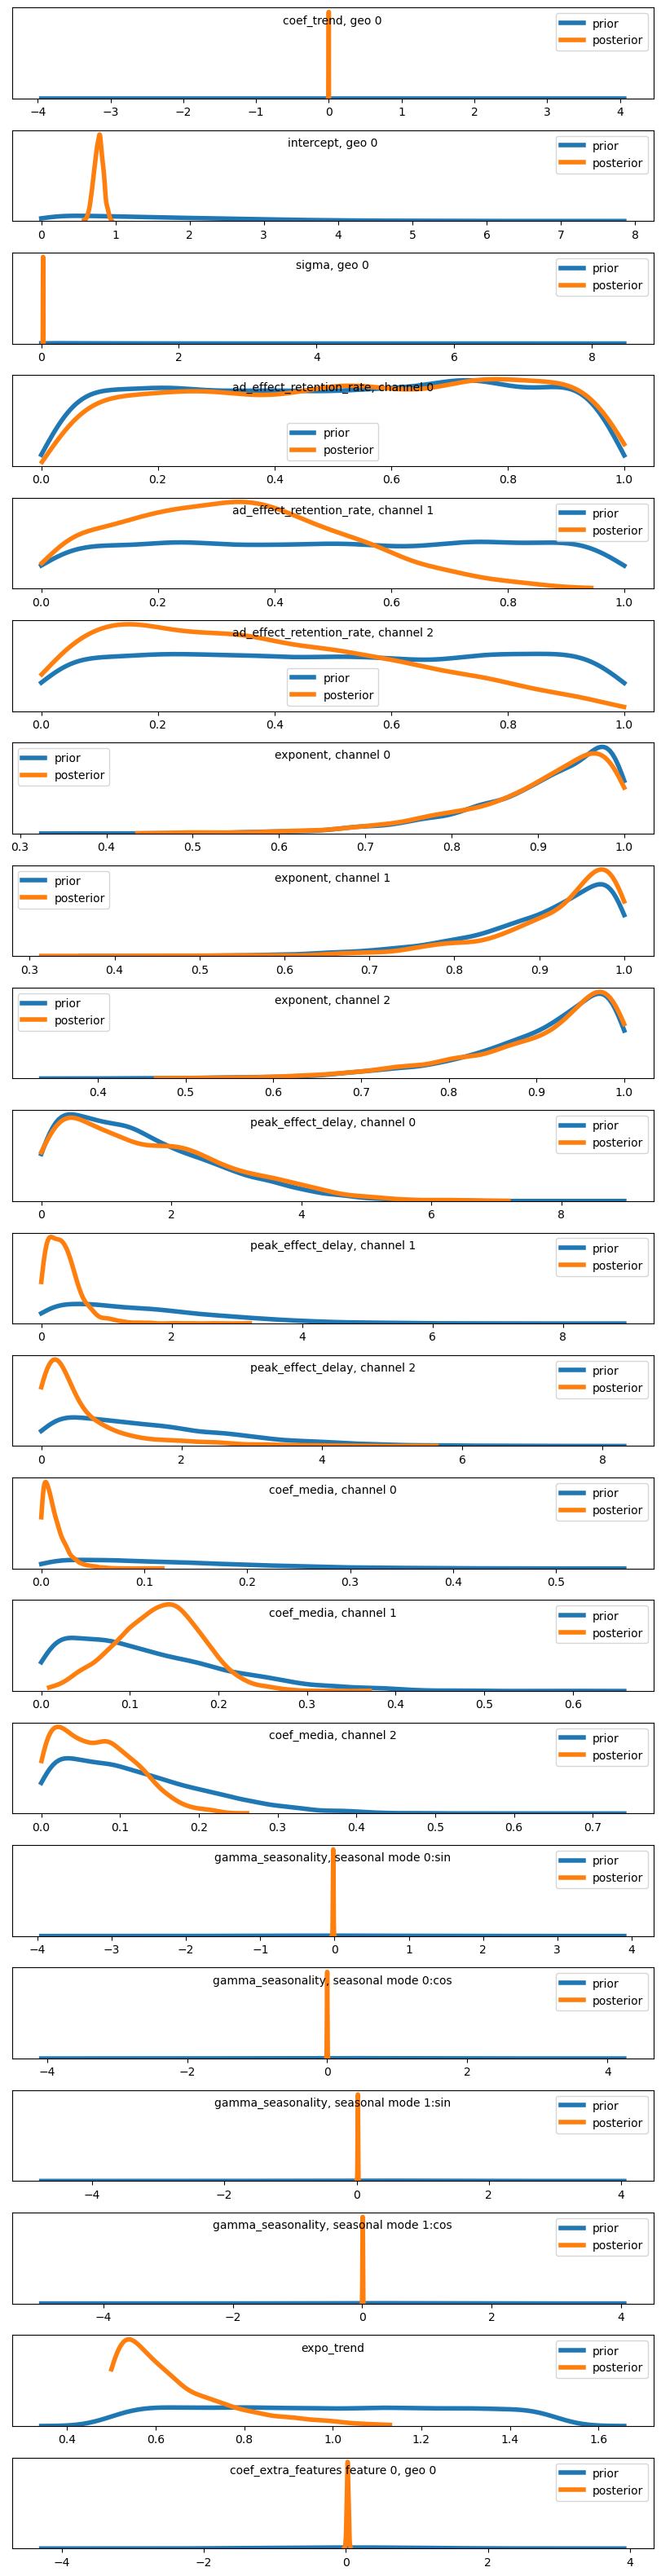

In [ ]:
plot.plot_prior_and_posterior(media_mix_model=mmm)

One can also check your model's fit to the training data.

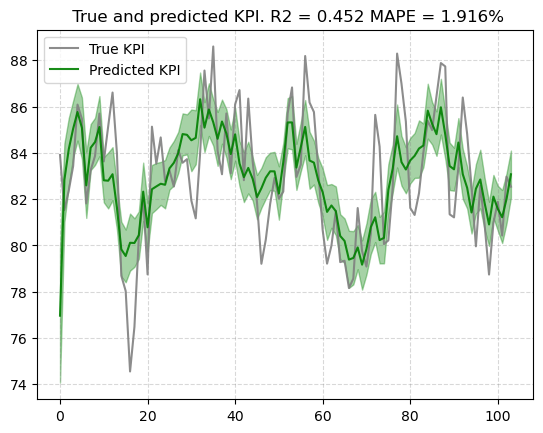

In [ ]:
# Here is another example where we can pass the target scaler if you want the plot to be in the "not scaled scale"
plot.plot_model_fit(mmm, target_scaler=target_scaler)

If one wants to run predictions on unseen data they can rely on the `predict`
method:

In [ ]:
# We have to scale the test media data if we have not done so before.
new_predictions = mmm.predict(media=media_scaler.transform(media_data_test),
                              extra_features=extra_features_scaler.transform(extra_features_test),
                              seed=SEED)
new_predictions.shape

(2000, 13)

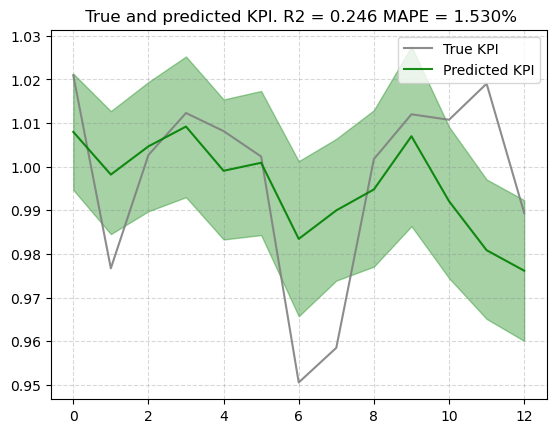

In [ ]:
plot.plot_out_of_sample_model_fit(out_of_sample_predictions=new_predictions,
                                 out_of_sample_target=target_scaler.transform(target[split_point:]))

### Media insights

In [ ]:
media_contribution, roi_hat = mmm.get_posterior_metrics(target_scaler=target_scaler, cost_scaler=cost_scaler)

We can quickly visualise the estimated media & baseline contribution over time

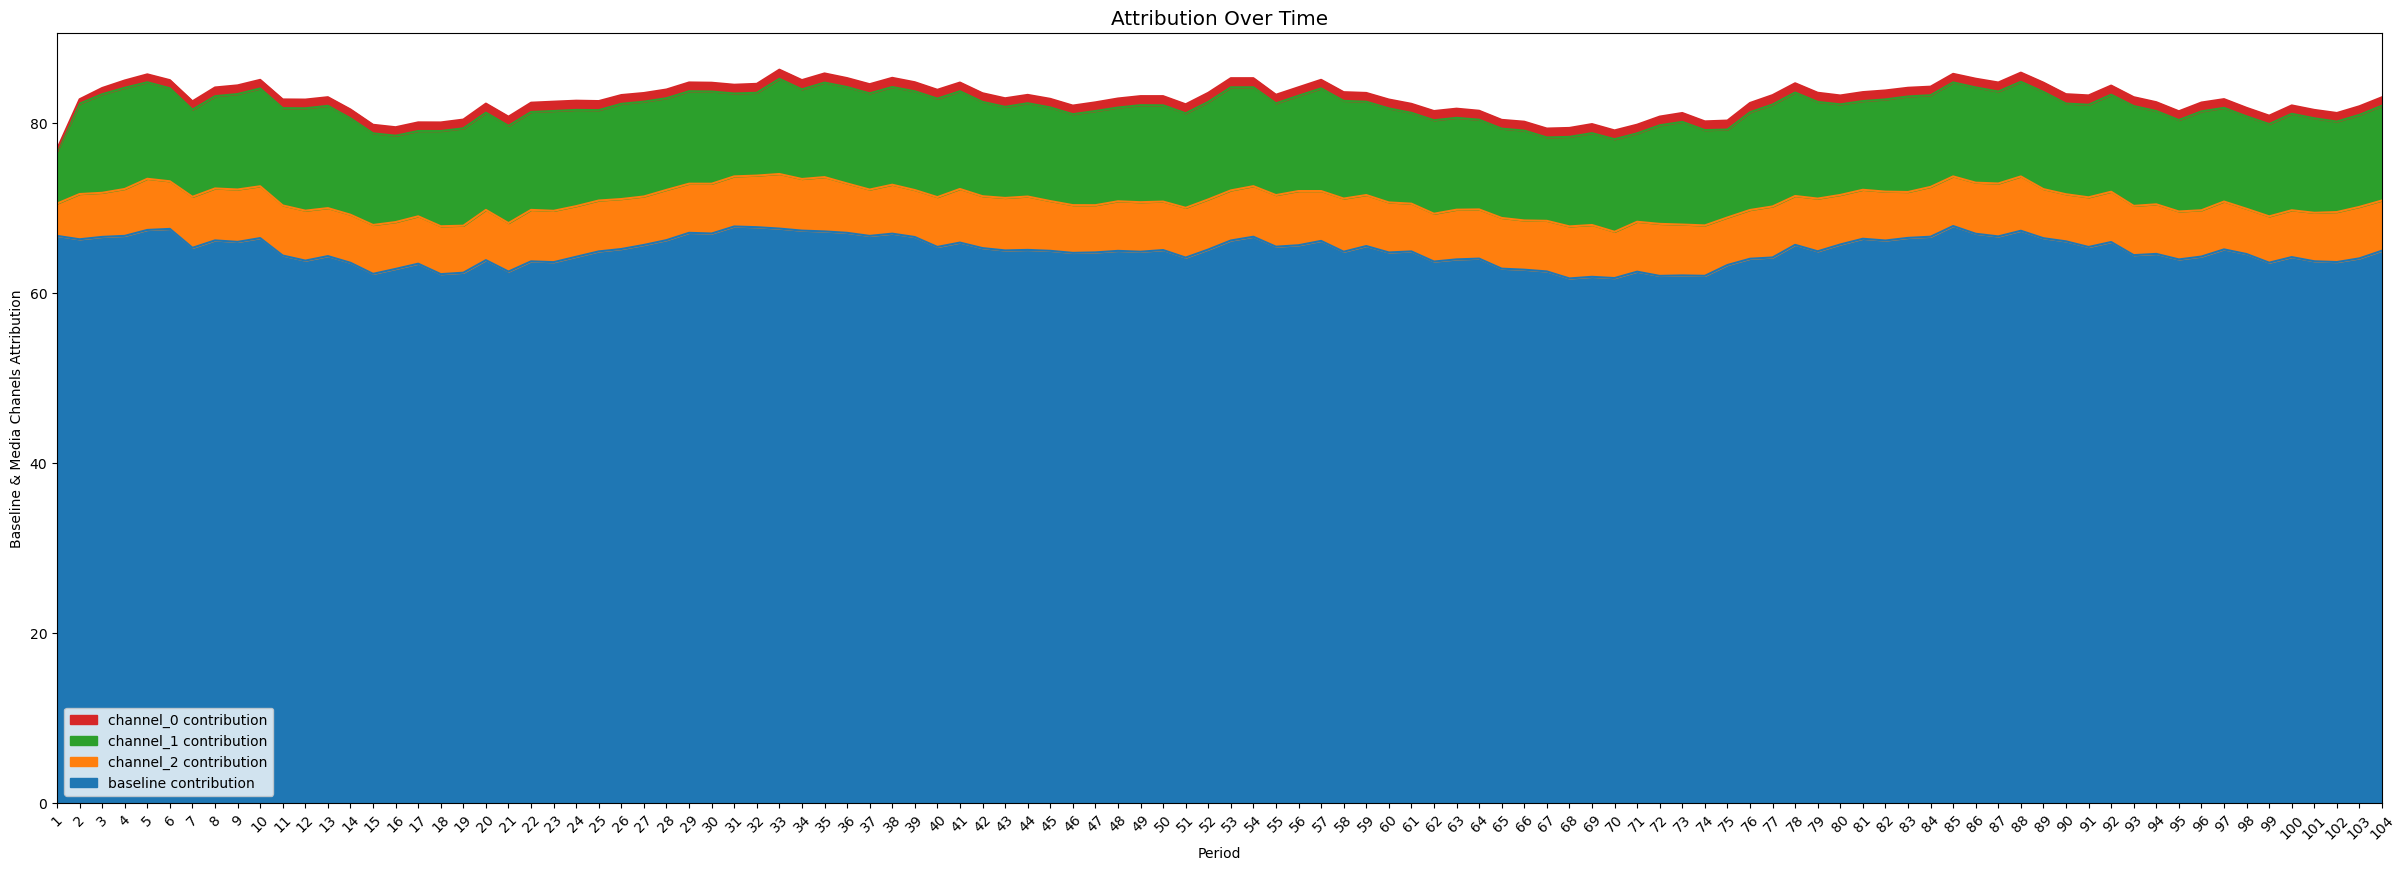

In [ ]:
plot.plot_media_baseline_contribution_area_plot(media_mix_model=mmm,
                                                target_scaler=target_scaler,
                                                fig_size=(30,10))

We can quickly visualise the estimated media contributions with their respective
credibility intervals

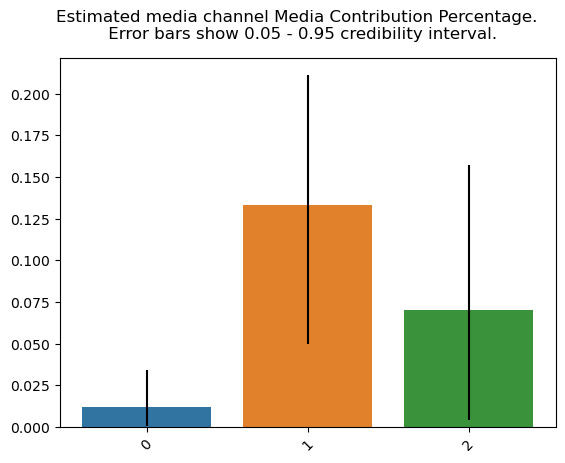

In [ ]:
plot.plot_bars_media_metrics(metric=media_contribution, metric_name="Media Contribution Percentage")

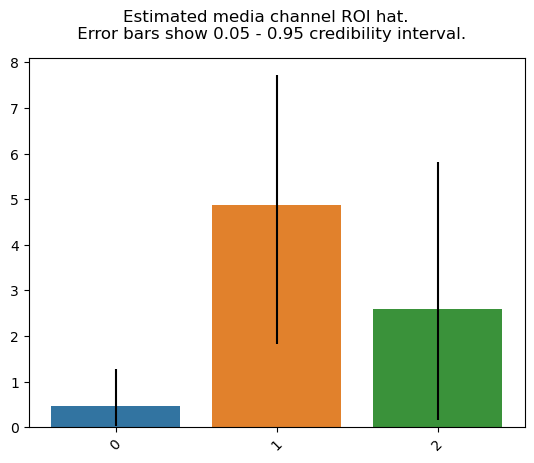

In [ ]:
plot.plot_bars_media_metrics(metric=roi_hat, metric_name="ROI hat")

Another vital question we can solve with MMMs is how each media channel behaves
individually as we invest more in it.

For that we can plot the curve response of all media channels with the following
function:

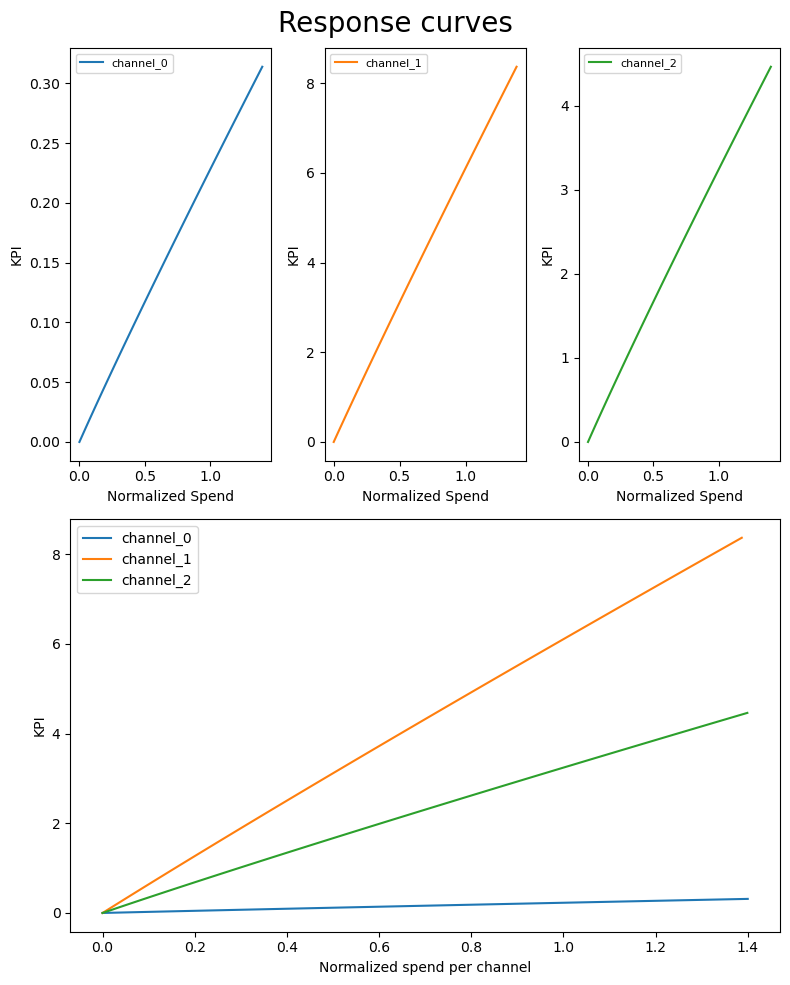

In [ ]:
plot.plot_response_curves(
    media_mix_model=mmm, target_scaler=target_scaler, seed=SEED)

### Optimization

The optimization is meant to solve the budget allocation questions for you.
First you need to provide for how long you want to optimize your budget (eg. 10
weeks in this case).

The optimization values will be bounded by +- 20% of the max and min historic
values used for training. Which means the optimization won't recommend to
completely change your strategy but how to make some budget re-allocation.

You can change that percentage with the following parameters:
- bounds_lower_pct
- bounds_upper_pct

Which can hold 1 value for all channels or 1 value per channel.

Prices are the average price you would expect for the media units of each
channel. If your data is already in monetary units (eg. $) your prices should be an array of 1s.

In [ ]:
prices = jnp.ones(mmm.n_media_channels)

The budget is how much one would like to allocate throughtout the total of
`n_time_periods`. Make sure this amount is inline with the historic spend or
otherwise some conditions/bounds in the optimization might not be met.

In [ ]:
n_time_periods = 10
budget = jnp.sum(jnp.dot(prices, media_data.mean(axis=0)))* n_time_periods

In [ ]:
# Run optimization with the parameters of choice.
solution, kpi_without_optim, previous_media_allocation = optimize_media.find_optimal_budgets(
    n_time_periods=n_time_periods,
    media_mix_model=mmm,
    extra_features=extra_features_scaler.transform(extra_features_test)[:n_time_periods],
    budget=budget,
    prices=prices,
    media_scaler=media_scaler,
    target_scaler=target_scaler,
    seed=SEED)

Optimization terminated successfully    (Exit mode 0)
            Current function value: -846.5485408201272
            Iterations: 8
            Function evaluations: 56
            Gradient evaluations: 8


If your media data is not in monetary units (eg. impressions, clicks, GRPs, etc.), you would need to store the cost per values (eg. CPC) in the prices array and multiply it by solution.x to get the recommended budget allocation.



In [ ]:
# Obtain the optimal weekly allocation.
optimal_buget_allocation = prices * solution.x
optimal_buget_allocation

DeviceArray([160.70435, 241.3611 , 200.31541], dtype=float32)

In [ ]:
# similar renormalization to get previous budget allocation
previous_budget_allocation = prices * previous_media_allocation
previous_budget_allocation

DeviceArray([200.82388, 201.07762, 200.47934], dtype=float32)

In [ ]:
# Both these values should be very close in order to compare KPI
budget, optimal_buget_allocation.sum()

(DeviceArray(602.38086, dtype=float32), DeviceArray(602.38086, dtype=float32))

We can double check the budget constraint was met:

In [ ]:
# Both numbers should be almost equal
budget, jnp.sum(solution.x * prices)

(DeviceArray(602.38086, dtype=float32), DeviceArray(602.38086, dtype=float32))

## We can plot the following:
1. Pre post optimization budget allocation comparison for each channel
2. Pre post optimization predicted target variable comparison

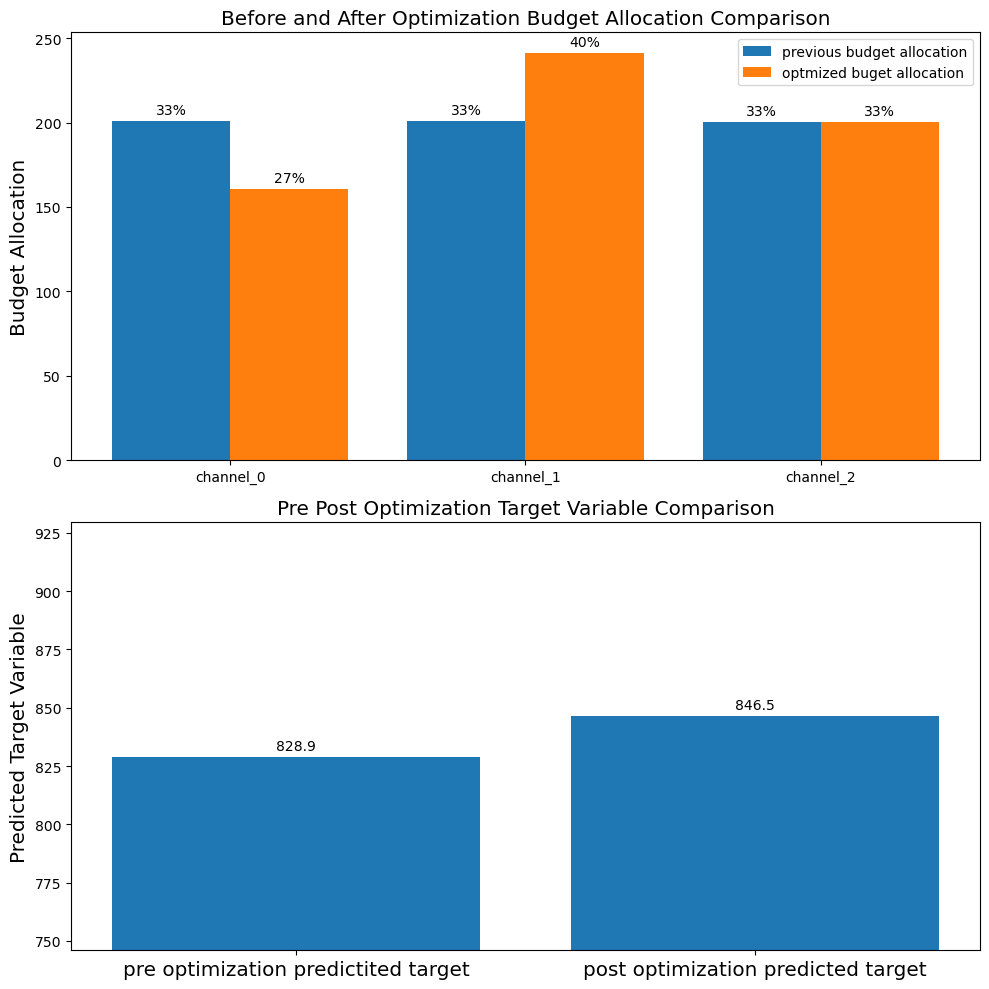

In [ ]:
# Plot out pre post optimization budget allocation and predicted target variable comparison.
plot.plot_pre_post_budget_allocation_comparison(media_mix_model=mmm, 
                                                kpi_with_optim=solution['fun'], 
                                                kpi_without_optim=kpi_without_optim,
                                                optimal_buget_allocation=optimal_buget_allocation, 
                                                previous_budget_allocation=previous_budget_allocation, 
                                                figure_size=(10,10))

## Saving the model to disk

In [ ]:
# We can use the utilities for saving models to disk.
file_path = "media_mix_model.pkl"
utils.save_model(media_mix_model=mmm, file_path=file_path)

In [ ]:
# Once saved one can load the models.
loaded_mmm = utils.load_model(file_path=file_path)
loaded_mmm.trace["coef_media"].shape # Example of accessing any of the model values.

(2000, 3)